In [ ]:
!pip install -U flatland-rl

In [ ]:
from flatland.envs.rail_env import RailEnv
from flatland.envs.rail_generators import sparse_rail_generator
from flatland.envs.line_generators import sparse_line_generator
from flatland.envs.observations import GlobalObsForRailEnv


rail_generator = sparse_rail_generator(max_num_cities=2)

# Initialize the properties of the environment
random_env = RailEnv(
    width=24,
    height=24,
    number_of_agents=1,
    rail_generator=rail_generator,
    line_generator=sparse_line_generator(),
    obs_builder_object=GlobalObsForRailEnv()
)

# Call reset() to initialize the environment
observation, info = random_env.reset()

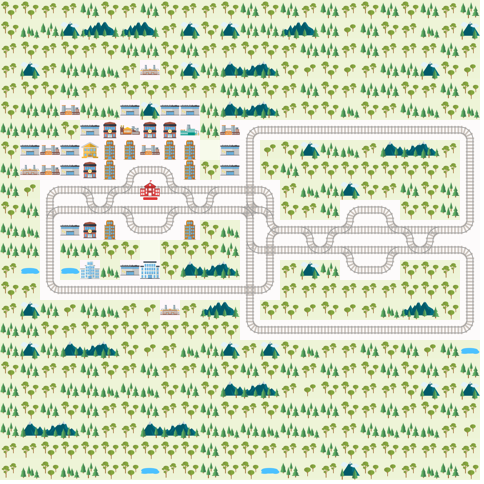

In [ ]:
import PIL
from flatland.utils.rendertools import RenderTool
from IPython.display import clear_output


# Render the environment
def render_env(env,wait=True):

    env_renderer = RenderTool(env, gl="PILSVG")
    env_renderer.render_env()

    image = env_renderer.get_image()
    pil_image = PIL.Image.fromarray(image)
    clear_output(wait=True)
    display(pil_image)

render_env(random_env)

In [ ]:
import numpy as np

for agent_handle in random_env.get_agent_handles():
    print('Observations for agent {}:'.format(agent_handle))
    agent_obs = observation[agent_handle]

    print('- Transition map\n{}\n'.format(np.transpose(agent_obs[0], (2, 0, 1))))
    print('- Agent position\n{}\n'.format(np.transpose(agent_obs[1], (2, 0, 1))))
    print('- Agent target \n{}\n'.format(np.transpose(agent_obs[2], (2, 0, 1))))

Observations for agent 0:
- Transition map
[[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 ...

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0.

In [ ]:
class RandomController:
    def __init__(self, action_size):
        self.action_size = action_size

    def act(self, observations):
        actions = dict()
        for agent_handle, observation in enumerate(observations):
            action = np.random.randint(self.action_size)
            actions.update({agent_handle: action})
        return actions

In [ ]:
from flatland.envs.rail_env import RailEnvActions

controller = RandomController(random_env.action_space[0])
observations, info = random_env.reset()
actions = controller.act(observations)

# Perform a single action per agent
for (handle, action) in actions.items():
    print('Agent {} will perform action {} ({})'.format(handle, action, RailEnvActions.to_char(action)))
    next_obs, all_rewards, dones, info = random_env.step({handle: action})

print('Rewards for each agent: {}'.format(all_rewards))
print('Done for each agent: {}'.format(dones))
print('Misc info: {}'.format(info))

Agent 0 will perform action 1 (L)
Rewards for each agent: {0: 0}
Done for each agent: {0: False, '__all__': False}
Misc info: {'action_required': {0: False}, 'malfunction': {0: 0}, 'speed': {0: 1.0}, 'state': {0: <TrainState.WAITING: 0>}}


/usr/local/lib/python3.10/dist-packages/flatland/envs/rail_generators.py:303: UserWarning: Could not set all required cities! Created 1/2
  warnings.warn(city_warning)
/usr/local/lib/python3.10/dist-packages/flatland/envs/rail_generators.py:215: UserWarning: [WARNING] Changing to Grid mode to place at least 2 cities.
  warnings.warn("[WARNING] Changing to Grid mode to place at least 2 cities.")


In [ ]:
def run_episode(env):
    controller = RandomController(env.action_space[0])
    observations, info = env.reset()

    score = 0
    actions = dict()

    for step in range(50):

        actions = controller.act(observations)
        next_observations, all_rewards, dones, info = env.step(actions)
        for agent_handle in env.get_agent_handles():
            score += all_rewards[agent_handle]

        render_env(env)
        print('Timestep {}, total score = {}'.format(step, score))

        if dones['__all__']:
            print('All done!')
            return

    print("Episode didn't finish after 50 timesteps.")

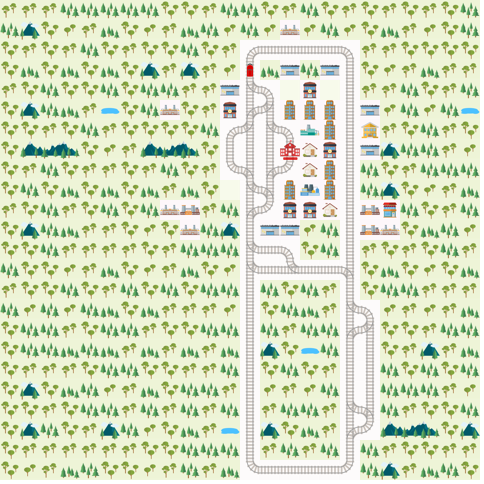

Timestep 48, total score = -54
All done!


In [ ]:
run_episode(random_env)

**Sequential Agent**

In [ ]:
import numpy as np
from flatland.envs.observations import TreeObsForRailEnv
from flatland.envs.rail_env import RailEnv
from flatland.envs.rail_generators import sparse_rail_generator
from flatland.envs.line_generators import sparse_line_generator
from flatland.envs.predictions import ShortestPathPredictorForRailEnv
from flatland.utils.rendertools import RenderTool
from IPython.display import clear_output
import PIL
%matplotlib inline

In [ ]:
def render_env(env,wait=True):

    env_renderer = RenderTool(env, gl="PILSVG")
    env_renderer.render_env()

    image = env_renderer.get_image()
    pil_image = PIL.Image.fromarray(image)
    clear_output(wait=True)
    display(pil_image)

def min_gt(seq, val):
    """
    Return smallest item in seq for which item > val applies.
    None is returned if seq was empty or all items in seq were >= val.
    """
    min = np.inf
    idx = len(seq) - 1
    while idx >= 0:
        if seq[idx] >= val and seq[idx] < min:
            min = seq[idx]
        idx -= 1
    return min

In [ ]:
class OrderedAgent:

    def __init__(self):
        self.action_size = 5

    def act(self, state, eps=0):
        """
        :param state: input is the observation of the agent
        :return: returns an action
        """
        distance = []
        for direction in TreeObsForRailEnv.tree_explored_actions_char:
            try:
                distance.append(state.childs[direction].dist_min_to_target)
            except:
                distance.append(np.inf)
        distance = np.array(distance)
        min_dist = min_gt(distance, 0)
        min_direction = np.where(distance == min_dist)
        if len(min_direction[0]) > 1:
            return min_direction[0][-1] + 1
        return min_direction[0][0] + 1

In [ ]:
np.random.seed(2)
x_dim = 30  # np.random.randint(8, 20)
y_dim = 30  # np.random.randint(8, 20)
n_agents = 3  # np.random.randint(3, 8)
n_goals = n_agents + np.random.randint(0, 3)
min_dist = int(0.75 * min(x_dim, y_dim))

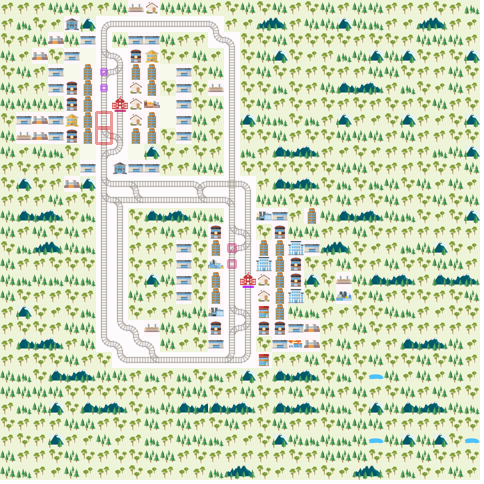

In [ ]:
env = RailEnv(width=x_dim,
              height=y_dim,
              rail_generator=sparse_rail_generator(),
              line_generator=sparse_line_generator(),
              obs_builder_object=TreeObsForRailEnv(max_depth=1,
              predictor=ShortestPathPredictorForRailEnv()),
              number_of_agents=n_agents)
env.reset()
render_env(env)

In [ ]:
def run_episode(env, agent, render = True):

    env_renderer = RenderTool(env)
    max_steps = 100 * (env.height + env.width)-1
    action_dict = dict()
    # Reset environment
    obs, info = env.reset(regenerate_rail = False,regenerate_schedule = False)
    done = env.dones
    env_renderer.reset()
    frame_step = 0
    score = 0
    # Run episode
    for step in range(max_steps):

        # Action
        acting_agent = 0
        for a in range(env.get_num_agents()):
            if done[a]:
                acting_agent += 1
            if a == acting_agent:
                action = agent.act(obs[a])
            else:
                action = 4
            action_dict.update({a: action})
        # Environment step

        obs, all_rewards, done, _ = env.step(action_dict)
        for agent_handle in env.get_agent_handles():
            score += all_rewards[agent_handle]
        print('Timestep {}, total score = {}'.format(step, score))


        if done['__all__']:
            print('All done')
            break

        # Render
        if render:
            render_env(env)
        else:
            clear_output()

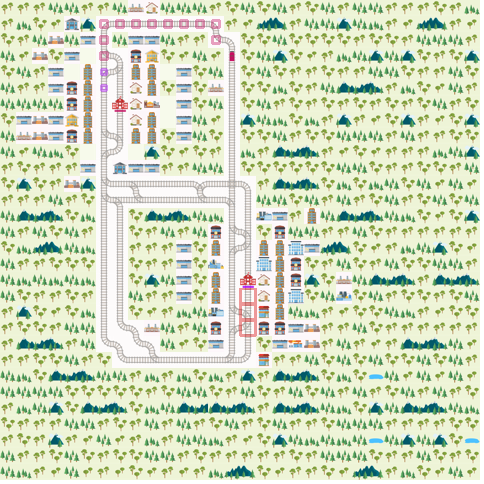

Timestep 50, total score = -57
All done


In [ ]:
run_episode(env,OrderedAgent())

In [ ]:
class RandomController:
    def __init__(self, action_size):
        self.action_size = action_size

    def act(self, observations):
        actions = dict()
        return np.random.randint(self.action_size)

random_agent = RandomController(5)
run_episode(env,random_agent,False)

Timestep 50, total score = -57
All done


**LEVEL GENERATION**

In [ ]:
rail_generator=sparse_rail_generator(
    max_num_cities=2,
    grid_mode=False,
    max_rails_between_cities=2,
    max_rail_pairs_in_city=2,
    seed=0
)

env = RailEnv(
    width=30, height=30,
    rail_generator=rail_generator,
    line_generator=sparse_line_generator(),
    number_of_agents=10
)

env.reset()

({0: (array([[[0., 0., 0., ..., 0., 0., 0.],
           [0., 0., 0., ..., 0., 0., 0.],
           [0., 0., 0., ..., 0., 0., 0.],
           ...,
           [0., 0., 0., ..., 0., 0., 0.],
           [0., 0., 0., ..., 0., 0., 0.],
           [0., 0., 0., ..., 0., 0., 0.]],
   
          [[0., 0., 0., ..., 0., 0., 0.],
           [0., 0., 0., ..., 0., 0., 0.],
           [0., 0., 0., ..., 0., 0., 0.],
           ...,
           [0., 0., 0., ..., 0., 0., 0.],
           [0., 0., 0., ..., 0., 0., 0.],
           [0., 0., 0., ..., 0., 0., 0.]],
   
          [[0., 0., 0., ..., 0., 0., 0.],
           [0., 0., 0., ..., 0., 0., 0.],
           [0., 0., 0., ..., 0., 0., 0.],
           ...,
           [0., 0., 0., ..., 0., 0., 0.],
           [0., 0., 0., ..., 0., 0., 0.],
           [0., 0., 0., ..., 0., 0., 0.]],
   
          ...,
   
          [[0., 0., 0., ..., 0., 0., 0.],
           [0., 0., 0., ..., 0., 0., 0.],
           [0., 0., 0., ..., 0., 0., 0.],
           ...,
           [0., 0

In [ ]:
transition_list = [int('0000000000000000', 2),  # empty cell - Case 0
                   int('1000000000100000', 2),  # Case 1 - straight
                   int('1001001000100000', 2),  # Case 2 - simple switch
                   int('1000010000100001', 2),  # Case 3 - diamond drossing
                   int('1001011000100001', 2),  # Case 4 - single slip
                   int('1100110000110011', 2),  # Case 5 - double slip
                   int('0101001000000010', 2),  # Case 6 - symmetrical
                   int('0010000000000000', 2),  # Case 7 - dead end
                   int('0100000000000010', 2),  # Case 1b (8)  - simple turn right
                   int('0001001000000000', 2),  # Case 1c (9)  - simple turn left
                   int('1100000000100010', 2)]  # Case 2b (10) - simple switch mirrored

In [ ]:
import numpy as np

class MyAgent:
    def __init__(self, env):
        self.env = env

    def get_transitions(self, position, direction):
        """Gets cell transitions for the agent."""
        cell_transitions = self.env.rail.get_transitions(*position, direction)
        transition_bit = bin(self.env.rail.get_full_transitions(*position))

        total_transitions = transition_bit.count("1")
        num_transitions = np.count_nonzero(cell_transitions)

        # Detect Switches that can only be used by other agents.
        # Initialize unusable_switch_detected before the if statement
        unusable_switch_detected = False
        if total_transitions > 2 > num_transitions:
            unusable_switch_detected = True

        return cell_transitions, total_transitions, num_transitions, unusable_switch_detected

# Example usage:
# Assuming 'env' is your RailEnv instance and 'position', 'direction' are defined
agent = MyAgent(env)
# Define position and direction before calling get_transitions
position = (1, 2)  # Example position - replace with your desired values
direction = 0  # Example direction - replace with your desired values (0-3)
cell_transitions, total_transitions, num_transitions, unusable_switch_detected = agent.get_transitions(position, direction)

In [ ]:
!pip install flatland-rl
from flatland.envs.observations import ObservationBuilder
import numpy as np

class SimpleObs(ObservationBuilder):
    """
    Simplest observation builder. The object returns observation vectors with 5 identical components,
    all equal to the ID of the respective agent.
    """

    def reset(self):
        return

    def get(self, handle):
        observation = handle * np.ones(5)
        return observation

In [ ]:

env = RailEnv(width=30,
              height=30,
              number_of_agents=3,
              rail_generator=sparse_rail_generator(),
              line_generator=sparse_line_generator(),
              obs_builder_object=SimpleObs())

env.reset()

({0: array([0., 0., 0., 0., 0.]),
  1: array([1., 1., 1., 1., 1.]),
  2: array([2., 2., 2., 2., 2.])},
 {'action_required': {0: False, 1: False, 2: False},
  'malfunction': {0: 0, 1: 0, 2: 0},
  'speed': {0: 1.0, 1: 1.0, 2: 1.0},
  'state': {0: <TrainState.WAITING: 0>,
   1: <TrainState.WAITING: 0>,
   2: <TrainState.WAITING: 0>}})

In [ ]:
from flatland.envs.observations import TreeObsForRailEnv

class SingleAgentNavigationObs(TreeObsForRailEnv):
    """
    We derive our observation builder from TreeObsForRailEnv, to exploit the existing implementation to compute
    the minimum distances from each grid node to each agent's target.

    We then build a representation vector with 3 binary components, indicating which of the 3 available directions
    for each agent (Left, Forward, Right) lead to the shortest path to its target.
    E.g., if taking the Left branch (if available) is the shortest route to the agent's target, the observation vector
    will be [1, 0, 0].
    """
    def __init__(self):
        super().__init__(max_depth=0)
        # We set max_depth=0 in because we only need to look at the current
        # position of the agent to decide what direction is shortest.

    def reset(self):
        # Recompute the distance map, if the environment has changed.
        super().reset()

    def get(self, handle):
        # Here we access agent information from the environment.
        # Information from the environment can be accessed but not changed!
        agent = self.env.agents[handle]

        # Check if agent.position is None and handle it
        if agent.position is None:
            # If agent.position is None, it might mean the agent is done or hasn't started yet.
            # You can return a default observation or raise an exception depending on your logic.
            # Here, we return a default observation of [0, 0, 0]
            return [0, 0, 0]
            # Alternatively, you can raise an exception:
            # raise ValueError(f"Agent {handle} has an invalid position (None).")

        possible_transitions = self.env.rail.get_transitions(*agent.position, agent.direction)
        num_transitions = np.count_nonzero(possible_transitions)

        # Start from the current orientation, and see which transitions are available;
        # organize them as [left, forward, right], relative to the current orientation
        # If only one transition is possible, the forward branch is aligned with it.
        if num_transitions == 1:
            observation = [0, 1, 0]
        else:
            min_distances = []
            for direction in [(agent.direction + i) % 4 for i in range(-1, 2)]:
                if possible_transitions[direction]:
                    new_position = self._new_position(agent.position, direction)
                    min_distances.append(self.env.distance_map.get()[handle, new_position[0], new_position[1], direction])
                else:
                    min_distances.append(np.inf)

            observation = [0, 0, 0]
            observation[np.argmin(min_distances)] = 1

        return observation

In [ ]:
class ObservePredictions(TreeObsForRailEnv):
    """
    We use the provided ShortestPathPredictor to illustrate the usage of predictors in your custom observation.

    We derive our observation builder from TreeObsForRailEnv, to exploit the existing implementation to compute
    the minimum distances from each grid node to each agent's target.

    This is necessary so that we can pass the distance map to the ShortestPathPredictor

    Here we also want to highlight how you can visualize your observation
    """

    def __init__(self, predictor):
        super().__init__(max_depth=0)
        self.predictor = predictor

    def reset(self):
        # Recompute the distance map, if the environment has changed.
        super().reset()

    def get_many(self, handles=None):
        '''
        Because we do not want to call the predictor seperately for every agent we implement the get_many function
        Here we can call the predictor just once for all the agents and use the predictions to generate our observations
        :param handles:
        :return:
        '''

        self.predictions = self.predictor.get()

        self.predicted_pos = {}
        for t in range(len(self.predictions[0])):
            pos_list = []
            for a in handles:
                pos_list.append(self.predictions[a][t][1:3])
            # We transform (x,y) coordinates to a single integer number for simpler comparison
            self.predicted_pos.update({t: coordinate_to_position(self.env.width, pos_list)})
        observations = {}

        # Collect all the different observation for all the agents
        for h in handles:
            observations[h] = self.get(h)
        return observations

    def get(self, handle):
        '''
        Lets write a simple observation which just indicates whether or not the own predicted path
        overlaps with other predicted paths at any time. This is useless for the task of navigation but might
        help when looking for conflicts. A more complex implementation can be found in the TreeObsForRailEnv class

        Each agent receives an observation of length 10, where each element represents a prediction step and its value
        is:
         - 0 if no overlap is happening
         - 1 if any other paths is crossing the predicted cell

        :param handle: handled as an index of an agent
        :return: Observation of handle
        '''

        observation = np.zeros(10)

        # We track what cells where considered while building the observation and make them accessible for rendering
        visited = set()

        for _idx in range(10):
            # Check if any of the other prediction overlap with agents own predictions
            x_coord = self.predictions[handle][_idx][1]
            y_coord = self.predictions[handle][_idx][2]

            # We add every observed cell to the observation rendering
            visited.add((x_coord, y_coord))
            if self.predicted_pos[_idx][handle] in np.delete(self.predicted_pos[_idx], handle, 0):
                # We detect if another agent is predicting to pass through the same cell at the same predicted time
                observation[handle] = 1

        # This variable will be access by the renderer to visualize the observation
        self.env.dev_obs_dict[handle] = visited

        return observation